# Description des images du jeu de données

## En bref
Le jeu comporte **84 916** images et il n'y a pas de valeurs manquantes pour cette modalité. Les images font **500x500px**, en **couleur** avec une profondeur de 24 bits et sont au format JPEG. Pour les images train, la taille moyenne est de 26,6 kB et la taille totale est de **2.23 GB**.

### Visualisations
Pour nous familiariser avec le jeu de données, nous avons effectué les visualisations suivantes:
- Graphique représentant les tailles des images
- Affichage d'images aléatoirement
- Affichage de 10 images groupées par classes pour toutes les classes

### Preprocessing
> _Utiliser les images directement n'est pas faisable à cause de la quantité astronomique de mémoire requise pour stocker l'ensembles des arrays numpy représentant les images. Par defaut, numpy utilise le format **float64** pour stocker les nombres  dans un array, et un nombre en float64 est stocké sur 8 bytes de mémoire. Pour un tableau de (500,500,3), on arrive à 6MB minimum par images. Soit **509.5 GB** de RAM minimum pour pouvoir stocker l'entièreté des images au sein d'arrays numpy._
>
> _Il était donc impératif de traiter les images. Pour cela, nous avons d'abord décidé de convertir les images en nuances de gris, ce qui divise le nombre d'élements utilisés pour représenter une image par 3._ <br>
_Le niveau de gris d'un pixel étant codé sur 256 valeurs, nous sommes passés au format uint8 de numpy (stocké sur 1 bytes - valeurs entre 0-255), ce qui a permis de diviser la mémoire nécessaire pour une image par 8 sans perte de qualité._ <br>
_Ce qui nous ramenait à 21 GB pour stocker l'entièreté des images. Meilleur, mais toujours trop._ <br>
_Nous nous sommes fixés de pouvoir stocker les images sur 6 GB maximum, ce qui équivaudrait à une résolution de 263x263px. Nous avons arrondis à **250x250px**. Pour la phase de construction du modèle, nous utiliserons cependant des images en **100x100px** pour faciliter l'entrainement et l'ajustement du modèle._

Pour le preprocessing, nous avons
- Converti les images en nuances de gris
- Recadré les images pour maximiser la taille du sujet (thresholding & recherche de contours)
- Réduit le format à 250x250px


### Imports


In [2]:
import joblib
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
sns.set_theme()

os.chdir("D:\Mathis one\Formations\Datascientest\Projet Rakuten")

df = pd.read_csv("data/X_train.csv", sep=",", index_col=0)
y_train = pd.read_csv("data/Y_train.csv", sep=",", index_col=0)
df = df.join(y_train)

img_sizes_path = 'D:\Mathis one\Formations\Datascientest\Projet Rakuten\scripts\img_train_sizes.joblib'
sizes = joblib.load(img_sizes_path)

### Affichage des tailles des images

Après avoir noté la problématique liée à la taille des images, nous avons voulu visualiser la répartition des tailles, et rechercher si certaines images avaient une taille abbérante. Pour récupérer les tailles, nous avons utilisé un script, puis avons exporté le tableau numpy avec toutes les tailles via joblib, et l'avons finalement réimporté dans ce notebook.

Ces graphiques nous permettent de conclure qu'il n'y a pas d'image de taille particulièrement abbérante. Cependant, ces métriques ne sont en fait par représentatives de la taille que prendra le dataset en mémoire car la taille des images est influencée par la compression du format JPEG, tandis que les arrays matplotlib ne sont pas compressés.

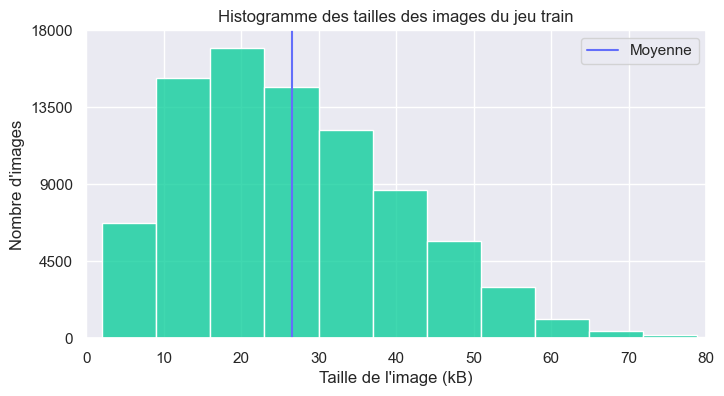

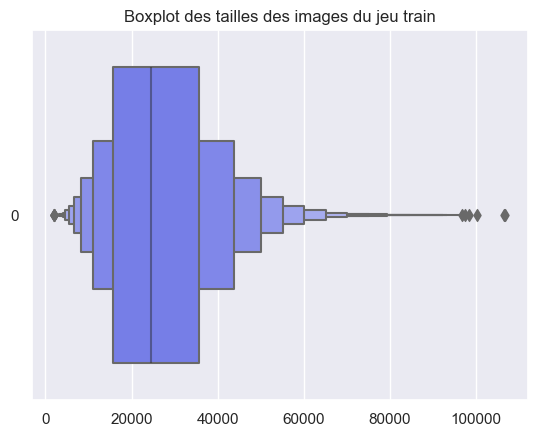

In [3]:
# Histogramme
plt.figure(figsize=(8,4))
sns.histplot(sizes/1000, bins=15, color="#00cc96")
plt.plot((sizes.mean()/1000, sizes.mean()/1000), (0, 20000), color="#636efa", label="Moyenne")
plt.ylim(top=18000)
plt.xlim((0,80))
plt.yticks(np.linspace(0,18000,5))
plt.xlabel("Taille de l'image (kB)")
plt.ylabel("Nombre d'images")
plt.title("Histogramme des tailles des images du jeu train")
plt.legend();

# Boxplot
plt.figure()
sns.boxenplot(sizes, orient="h", color="#636efa")
plt.title("Boxplot des tailles des images du jeu train");

### Affichage d'un échantillon aléatoire d'images

Nous avons ensuite cherché à avoir une vision d'ensemble du jeu de données, notamment en affichant un échantillon de n images prises aléatoirement dans le dataset. Nous avons également décidé d'afficher le code produit de chaque image pour augmenter la lisibilité.

C:\Users\Flying Cupcake\AppData\Local\Temp\ipykernel_21408\745754436.py:26: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(rows, cols, i+1)


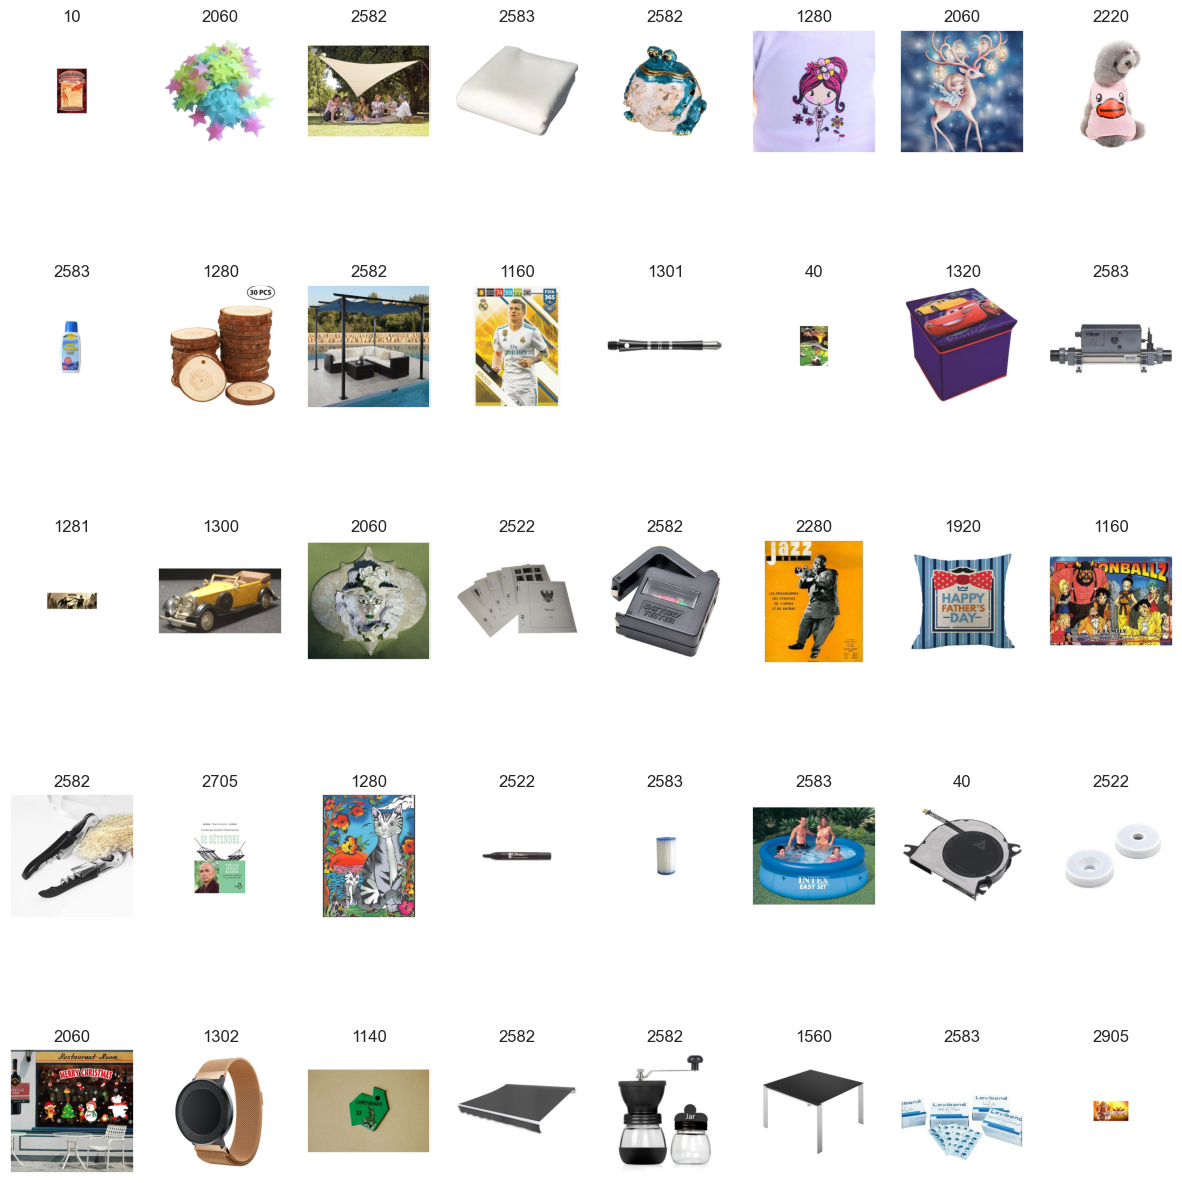

In [4]:
os.chdir("D:\Mathis one\Formations\Datascientest\Projet Rakuten\data\images\image_train")
images_number=40

def calculate_grid_dimensions(n):
    # Tries to fit images into a square, otherwise returns the closest matching rectangle
    sqrt_n = int(np.sqrt(n))
    rows, columns = sqrt_n, sqrt_n
    for i in range(sqrt_n, 0, -1):
        if n % i == 0:
            rows, columns = i, n // i
            break
    return rows, columns

rows, cols = calculate_grid_dimensions(images_number)
plt.figure(figsize=(rows*3,cols*2))
plt.title("{} images prélevés aléatoirement".format(images_number*images_number))

# Gets image_number random images from the set
for i in range(images_number):
    rand_id = np.random.randint(len(df))
    product_id = df.iloc[rand_id, 2]
    image_id = df.iloc[rand_id, 3]
    code = df.iloc[rand_id, -1]
    img = cv2.imread("image_{0}_product_{1}.jpg".format(image_id,product_id), cv2.IMREAD_COLOR)

    plt.subplot(rows, cols, i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(code)
    plt.xticks([])
    plt.yticks([])
    

plt.show()

### Affichage d'un échantillon d'image pour chaque catégorie

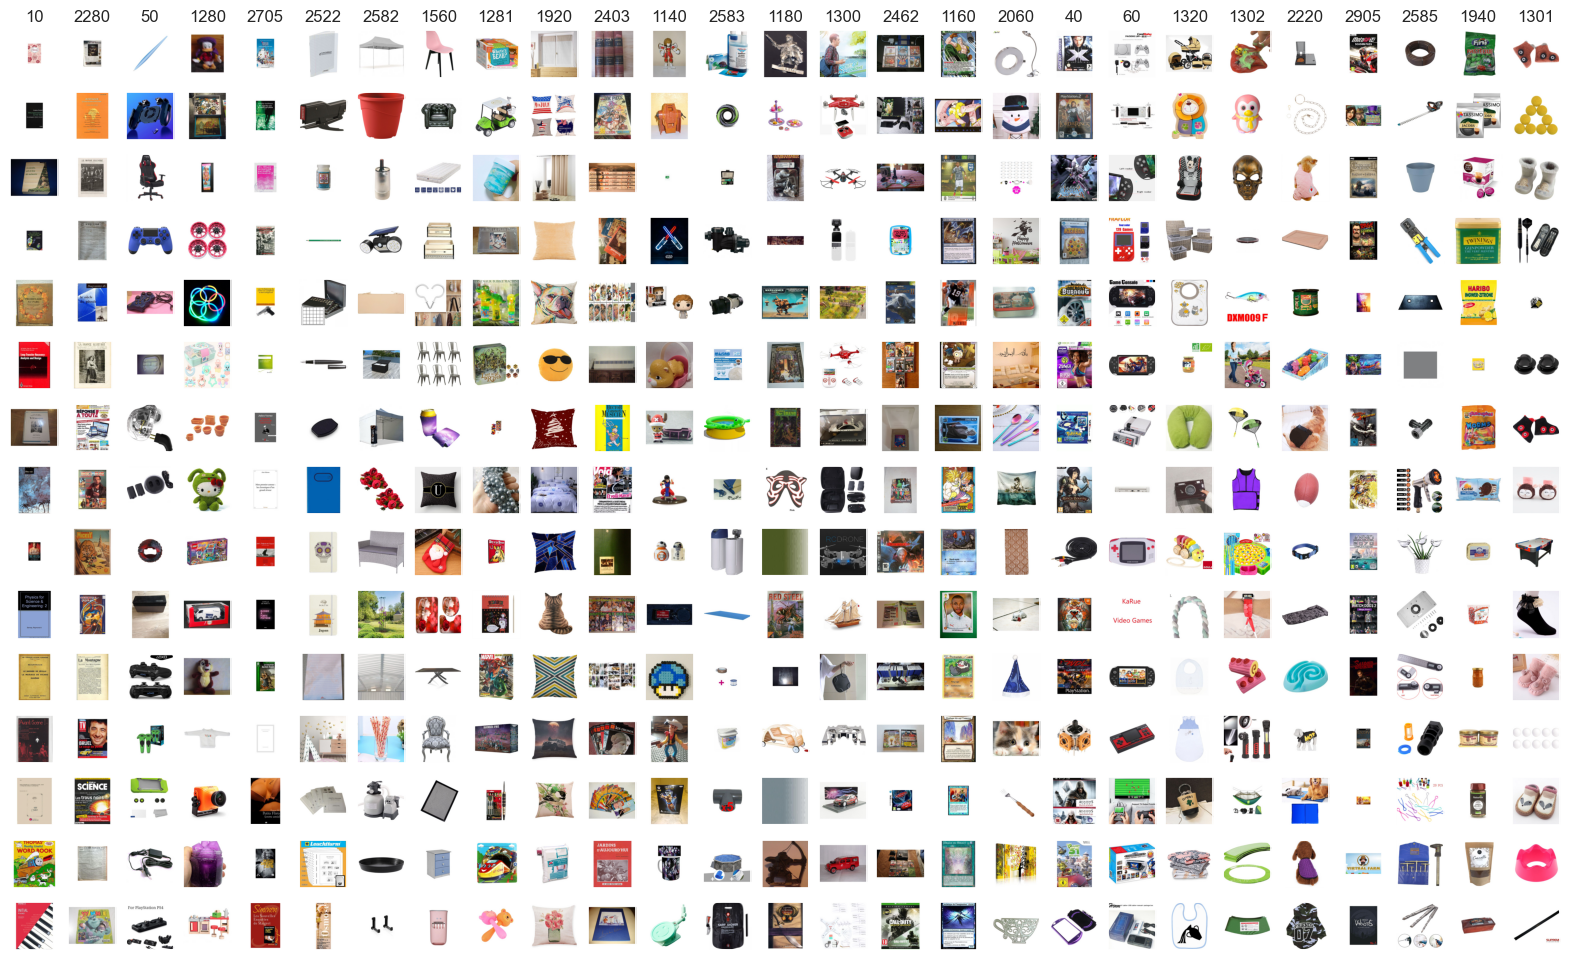

In [6]:
os.chdir("D:\Mathis one\Formations\Datascientest\Projet Rakuten\data\images\image_train")
images_per_class = 15

plt.figure(figsize=(20,images_per_class*0.8))
product_codes = df.prdtypecode.unique()

for code in range(len(product_codes)):
    # Keep track of where the next plot should be drawn
    plt_count = 0

    #Loops over all the images_per_class first images for each product code
    for img_index in df.loc[df.prdtypecode == product_codes[code], ["productid", "imageid"]].head(images_per_class).index:
        product_id = df.iloc[img_index, 2]
        image_id = df.iloc[img_index, 3]

        # Go to the correct subplot, with code specifying the column and plt_counts specifying the row
        plt.subplot(images_per_class, len(df.prdtypecode.unique()), code+plt_count*len(product_codes)+1)

        # Read and plot the image
        img = plt.imread("image_{0}_product_{1}.jpg".format(image_id,product_id))
        plt.imshow(img)
        if plt_count == 0:
            plt.title(str(product_codes[code]))
        plt.xticks([])
        plt.yticks([])

        # Switch to the next row
        plt_count +=1

plt.show()